In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor

In [2]:
# Load data
data = pd.read_csv("C:/Users/mrnai/OneDrive/Documents/Indiana University/Fall'24/AML CSCI P556/Project/cleaned_fixtures_final.csv")
data['season'] = pd.Categorical(data['season'], ordered=True)

data = data.drop(columns=['fixture', 'round'])

# Explore dataset
print(data.info())
print(data.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6080 entries, 0 to 6079
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   season           6080 non-null   category
 1   GW               6080 non-null   int64   
 2   team             6080 non-null   object  
 3   opponent_team    6080 non-null   object  
 4   was_home         6080 non-null   bool    
 5   team_score       6080 non-null   int64   
 6   opponent_score   6080 non-null   int64   
 7   Goal Difference  6080 non-null   int64   
dtypes: bool(1), category(1), int64(4), object(2)
memory usage: 297.4+ KB
None
    season  GW            team   opponent_team  was_home  team_score  \
0  2016-17   1         Burnley         Swansea      True           0   
1  2016-17   1         Swansea         Burnley     False           1   
2  2016-17   1  Crystal Palace       West Brom      True           0   
3  2016-17   1       West Brom  Crystal Palace     False 

In [3]:
def calculate_rolling_features(df, group_col, target_col, window=7, min_periods=1):
    """Helper function to calculate rolling mean for a target column grouped by a specific column."""
    return df.groupby(group_col)[target_col] \
             .rolling(window=window, min_periods=min_periods) \
             .mean() \
             .reset_index(level=0, drop=True)

def calculate_streaks(df, group_col, target_col, condition_func, window=5, min_periods=1):
    """Helper function to calculate streaks (winning/losing) based on condition."""
    return df.groupby(group_col)[target_col] \
             .apply(lambda x: condition_func(x).astype(int).rolling(window=window, min_periods=min_periods).sum()) \
             .reset_index(level=0, drop=True)

def feature_engineering(df):
    # Sort the dataframe by season, team, and game week
    df = df.sort_values(by=['season', 'team', 'GW']).reset_index(drop=True)

    # Team Features
    df['recent_form'] = calculate_rolling_features(df, 'team', 'team_score')
    df['recent_conceded'] = calculate_rolling_features(df, 'team', 'opponent_score')
    df['goal_diff_trend'] = calculate_rolling_features(df, 'team', 'Goal Difference')

    df['home_performance'] = df.groupby('team')['team_score'] \
                               .rolling(window=5, min_periods=1) \
                               .mean() \
                               .reset_index(level=0, drop=True)
    # Fill NaN values for away games with 0
    df['home_performance'] = df['home_performance'].fillna(0)

    # Winning and Losing streaks
    df['winning_streak'] = calculate_streaks(df, 'team', 'Goal Difference', lambda x: x > 0)
    df['losing_streak'] = calculate_streaks(df, 'team', 'Goal Difference', lambda x: x < 0)

    # Opponent Features (using similar logic for the opponent team)
    df['opponent_recent_form'] = calculate_rolling_features(df, 'opponent_team', 'team_score')
    df['opponent_recent_conceded'] = calculate_rolling_features(df, 'opponent_team', 'opponent_score')
    df['opponent_goal_diff_trend'] = calculate_rolling_features(df, 'opponent_team', 'Goal Difference')

    df['opponent_home_performance'] = df.groupby('opponent_team')['team_score'] \
                                         .rolling(window=5, min_periods=1) \
                                         .mean() \
                                         .reset_index(level=0, drop=True)

    # Opponent's winning and losing streaks
    df['opponent_winning_streak'] = calculate_streaks(df, 'opponent_team', 'Goal Difference', lambda x: x > 0)
    df['opponent_losing_streak'] = calculate_streaks(df, 'opponent_team', 'Goal Difference', lambda x: x < 0)

    return df

# Assuming 'data' is already loaded
data = feature_engineering(data)
print(data.head())

    season  GW     team opponent_team  was_home  team_score  opponent_score  \
0  2016-17   1  Arsenal     Liverpool      True           3               4   
1  2016-17   2  Arsenal     Leicester     False           0               0   
2  2016-17   3  Arsenal       Watford     False           3               1   
3  2016-17   4  Arsenal   Southampton      True           2               1   
4  2016-17   5  Arsenal          Hull     False           4               1   

   Goal Difference  recent_form  recent_conceded  goal_diff_trend  \
0               -1          3.0         4.000000        -1.000000   
1                0          1.5         2.000000        -0.500000   
2                2          2.0         1.666667         0.333333   
3                1          2.0         1.500000         0.500000   
4                3          2.4         1.400000         1.000000   

   home_performance  winning_streak  losing_streak  opponent_recent_form  \
0               3.0             0.

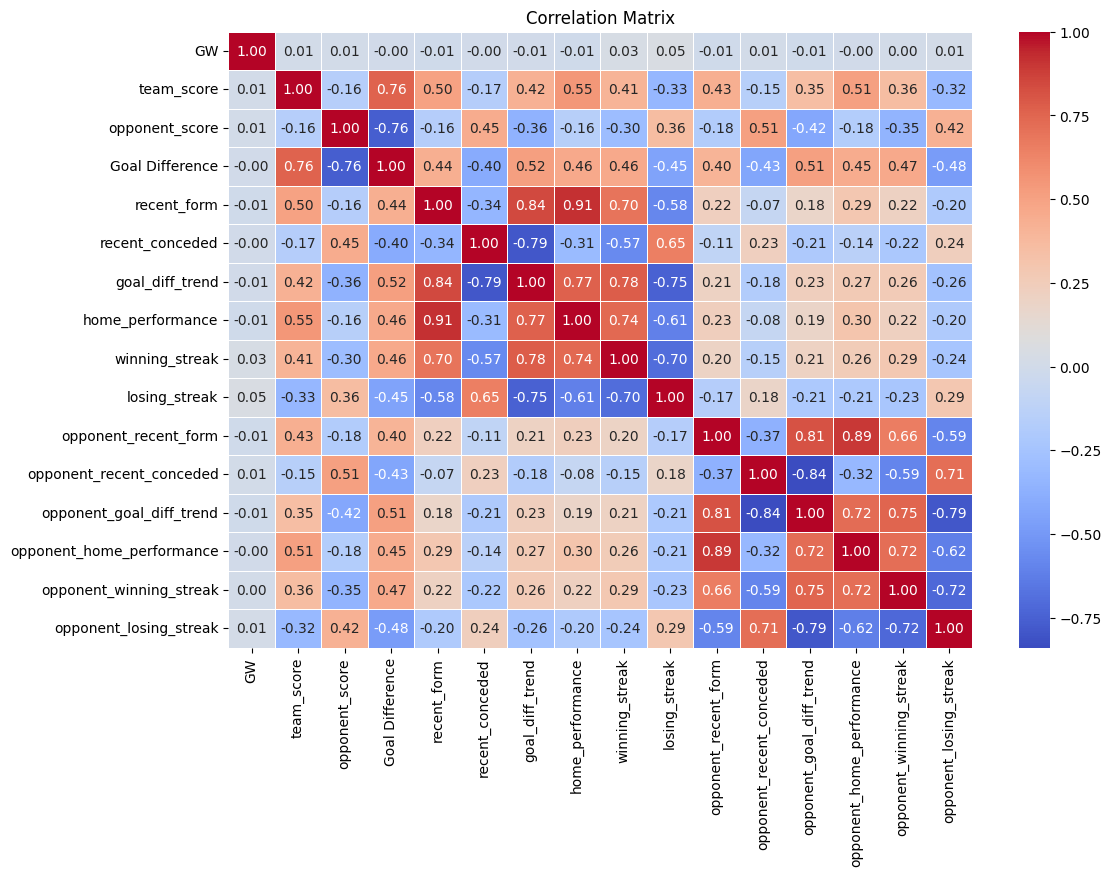

In [4]:
# Select only numeric columns for correlation calculation
numeric_data = data.select_dtypes(include=['number'])

# Calculate the correlation matrix
correlation_matrix = numeric_data.corr()

# Plot the correlation matrix (optional, for visualization)
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

In [5]:
# Split into training and testing sets
train_data = data[data['season'] != '2023-24']
test_data = data[data['season'] == '2023-24']

In [6]:
team_features = ['recent_form', 'recent_conceded', 'home_performance', 'goal_diff_trend', 'winning_streak', 'losing_streak']
opponent_features = ['opponent_recent_form', 'opponent_recent_conceded', 'opponent_home_performance', 'opponent_goal_diff_trend', 'opponent_winning_streak', 'opponent_losing_streak']

X_train = train_data[team_features + opponent_features]
y_train = train_data['Goal Difference']
X_test = test_data[team_features + opponent_features]
y_test = test_data['Goal Difference']

# Initialize the model

#model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)


# Train the model
model.fit(X_train, y_train)

# Predict on test set
predictions = model.predict(X_test)

In [7]:
# Explicitly use .loc to avoid SettingWithCopyWarning
test_data.loc[:, 'predicted_goal_diff'] = predictions

C:\Users\mrnai\AppData\Local\Temp\ipykernel_29792\1143314689.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.loc[:, 'predicted_goal_diff'] = predictions


In [8]:
team_stats = train_data.groupby('team').agg(
    total_wins=('Goal Difference', lambda x: (x > 0).sum()),
    total_games=('Goal Difference', 'size')
).reset_index()

# Calculate win percentage for each team
team_stats['win_percentage'] = (team_stats['total_wins'] / team_stats['total_games']) * 100
team_stats['rank'] = team_stats['win_percentage'].rank(ascending=False, method='min')

In [9]:
# Assign FDR based on rank
def assign_historical_fdr(rank):
    if rank <= 3:  # Top 3 teams
        return 5
    elif rank <= 6:  # Teams ranked 4-6
        return 4
    elif rank <= 9:  # Teams ranked 7-9
        return 3
    else:  # Teams ranked 10 or below
        return 2

# Apply the function to assign historical FDR based on rank
team_stats['historical_FDR'] = team_stats['rank'].apply(assign_historical_fdr)

In [10]:
# Map historical FDR to the teams in the original dataset
team_fdr_mapping = team_stats.set_index('team')['historical_FDR'].to_dict()
test_data['historical_FDR'] = data['opponent_team'].map(team_fdr_mapping)

# Default blank (NaN) values to 2
test_data['historical_FDR'] = test_data['historical_FDR'].fillna(2)

C:\Users\mrnai\AppData\Local\Temp\ipykernel_29792\2651234247.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['historical_FDR'] = data['opponent_team'].map(team_fdr_mapping)
C:\Users\mrnai\AppData\Local\Temp\ipykernel_29792\2651234247.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['historical_FDR'] = test_data['historical_FDR'].fillna(2)


In [11]:
test_data.head(10)

,season,GW,team,opponent_team,was_home,team_score,opponent_score,Goal Difference,recent_form,recent_conceded,...,winning_streak,losing_streak,opponent_recent_form,opponent_recent_conceded,opponent_goal_diff_trend,opponent_home_performance,opponent_winning_streak,opponent_losing_streak,predicted_goal_diff,historical_FDR
5320,2023-24,1,Arsenal,Nott'm Forest,True,2,1,1,1.857143,1.428571,...,3.0,2.0,1.857143,0.571429,1.285714,1.6,3.0,1.0,1.569451,2.0
5321,2023-24,2,Arsenal,Crystal Palace,False,1,0,1,1.857143,0.857143,...,3.0,2.0,1.857143,1.142857,0.714286,1.6,2.0,3.0,1.014383,2.0
5322,2023-24,3,Arsenal,Fulham,True,2,2,0,1.714286,1.000000,...,3.0,1.0,1.428571,0.714286,0.714286,1.4,2.0,0.0,1.277161,2.0
5323,2023-24,4,Arsenal,Man Utd,True,3,1,2,1.857143,1.142857,...,4.0,0.0,0.857143,1.285714,-0.428571,0.8,2.0,3.0,0.754393,4.0
5324,2023-24,5,Arsenal,Everton,False,1,0,1,2.000000,0.714286,...,4.0,0.0,1.285714,0.571429,0.714286,1.2,3.0,1.0,1.315616,2.0
5325,2023-24,6,Arsenal,Spurs,True,2,2,0,2.285714,0.857143,...,3.0,0.0,1.142857,1.857143,-0.714286,0.8,1.0,2.0,0.656778,5.0
5326,2023-24,7,Arsenal,Bournemouth,False,4,0,4,2.142857,0.857143,...,3.0,0.0,2.142857,0.857143,1.285714,2.0,3.0,1.0,1.831147,2.0
5327,2023-24,8,Arsenal,Man City,True,1,0,1,2.000000,0.714286,...,4.0,0.0,0.571429,2.142857,-1.571429,0.2,1.0,4.0,0.478402,5.0
5328,2023-24,9,Arsenal,Chelsea,False,2,2,0,2.142857,1.000000,...,3.0,0.0,1.285714,1.428571,-0.142857,1.0,1.0,2.0,0.705018,4.0
5329,2023-24,10,Arsenal,Sheffield Utd,True,5,0,5,2.571429,0.714286,...,3.0,0.0,2.000000,0.285714,1.714286,2.4,5.0,0.0,3.025679,2.0


In [12]:
# Use weighted average for FDR calculation (80-20 split between opponent's and team's features)
test_data['weighted_pred_goal_diff'] = (
    0.2 * test_data['predicted_goal_diff'] + 0.8 * test_data['opponent_recent_form']
)

test_data.loc[:, 'current_FDR'] = pd.cut(
    test_data['weighted_pred_goal_diff'], 
    bins=[-np.inf, -1, 0, 1, 2, np.inf], 
    labels=[5, 4, 3, 2, 1],  # Unique labels
    ordered=True
).astype(int)

test_data['FDR'] = (
    0.75 * test_data['current_FDR'] + 0.25 * test_data['historical_FDR']
).round(0)

test_data.head(10)

C:\Users\mrnai\AppData\Local\Temp\ipykernel_29792\930005979.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['weighted_pred_goal_diff'] = (
C:\Users\mrnai\AppData\Local\Temp\ipykernel_29792\930005979.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.loc[:, 'current_FDR'] = pd.cut(
C:\Users\mrnai\AppData\Local\Temp\ipykernel_29792\930005979.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

,season,GW,team,opponent_team,was_home,team_score,opponent_score,Goal Difference,recent_form,recent_conceded,...,opponent_recent_conceded,opponent_goal_diff_trend,opponent_home_performance,opponent_winning_streak,opponent_losing_streak,predicted_goal_diff,historical_FDR,weighted_pred_goal_diff,current_FDR,FDR
5320,2023-24,1,Arsenal,Nott'm Forest,True,2,1,1,1.857143,1.428571,...,0.571429,1.285714,1.6,3.0,1.0,1.569451,2.0,1.799604,2,2.0
5321,2023-24,2,Arsenal,Crystal Palace,False,1,0,1,1.857143,0.857143,...,1.142857,0.714286,1.6,2.0,3.0,1.014383,2.0,1.688591,2,2.0
5322,2023-24,3,Arsenal,Fulham,True,2,2,0,1.714286,1.000000,...,0.714286,0.714286,1.4,2.0,0.0,1.277161,2.0,1.398289,2,2.0
5323,2023-24,4,Arsenal,Man Utd,True,3,1,2,1.857143,1.142857,...,1.285714,-0.428571,0.8,2.0,3.0,0.754393,4.0,0.836593,3,3.0
5324,2023-24,5,Arsenal,Everton,False,1,0,1,2.000000,0.714286,...,0.571429,0.714286,1.2,3.0,1.0,1.315616,2.0,1.291695,2,2.0
5325,2023-24,6,Arsenal,Spurs,True,2,2,0,2.285714,0.857143,...,1.857143,-0.714286,0.8,1.0,2.0,0.656778,5.0,1.045641,2,3.0
5326,2023-24,7,Arsenal,Bournemouth,False,4,0,4,2.142857,0.857143,...,0.857143,1.285714,2.0,3.0,1.0,1.831147,2.0,2.080515,1,1.0
5327,2023-24,8,Arsenal,Man City,True,1,0,1,2.000000,0.714286,...,2.142857,-1.571429,0.2,1.0,4.0,0.478402,5.0,0.552823,3,4.0
5328,2023-24,9,Arsenal,Chelsea,False,2,2,0,2.142857,1.000000,...,1.428571,-0.142857,1.0,1.0,2.0,0.705018,4.0,1.169575,2,2.0
5329,2023-24,10,Arsenal,Sheffield Utd,True,5,0,5,2.571429,0.714286,...,0.285714,1.714286,2.4,5.0,0.0,3.025679,2.0,2.205136,1,1.0


In [13]:
test_data[['season', 'GW', 'team', 'opponent_team','was_home','FDR']].to_csv("FDR_2023_24.csv", index=False)

In [14]:
# Evaluate
r2 = r2_score(y_test, predictions)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"R²: {r2:.2f}")
print(f"RMSE: {rmse:.2f}")


R²: 0.47
RMSE: 1.51


C:\Users\mrnai\AppData\Local\Temp\ipykernel_29792\981148757.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances, y=feature_names, palette='viridis')


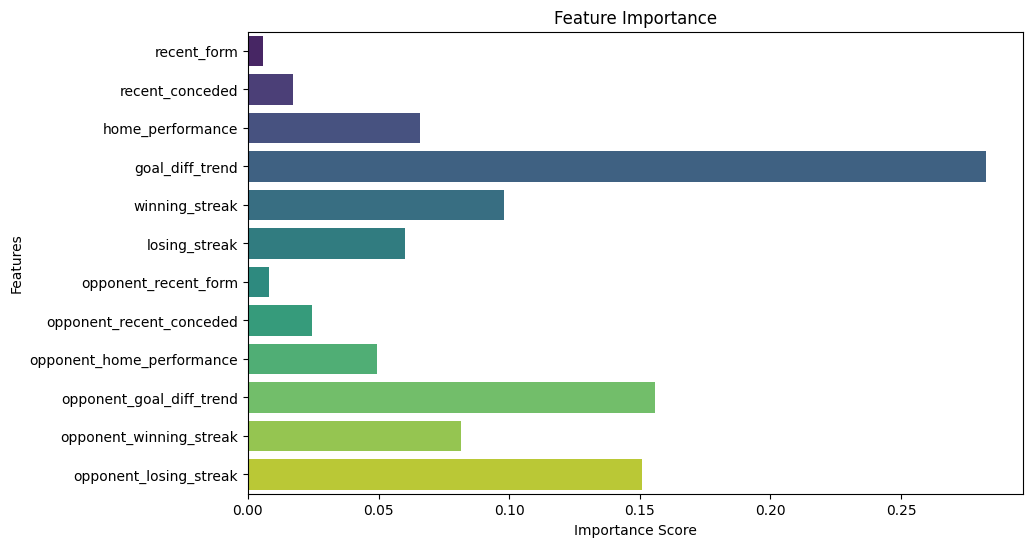

In [15]:
# Feature Importance (for tree-based models like XGBRegressor)
importances = model.feature_importances_
feature_names = team_features + opponent_features
plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=feature_names, palette='viridis')
plt.title("Feature Importance")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.show()


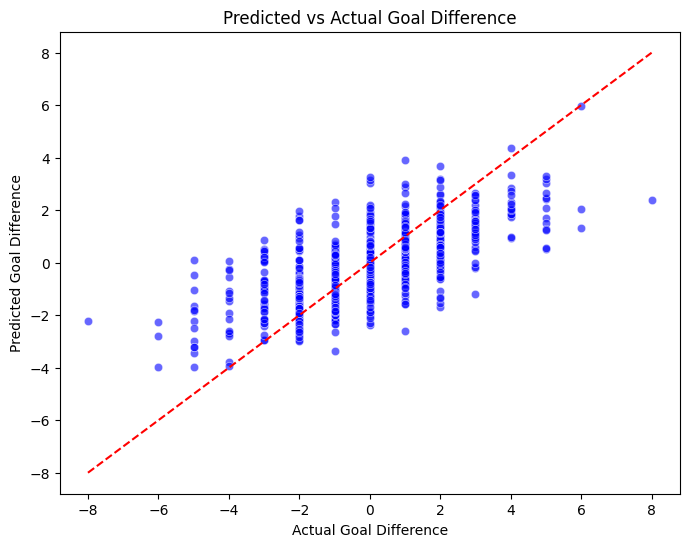

In [16]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=predictions, alpha=0.6, color="blue")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.title("Predicted vs Actual Goal Difference")
plt.xlabel("Actual Goal Difference")
plt.ylabel("Predicted Goal Difference")
plt.show()


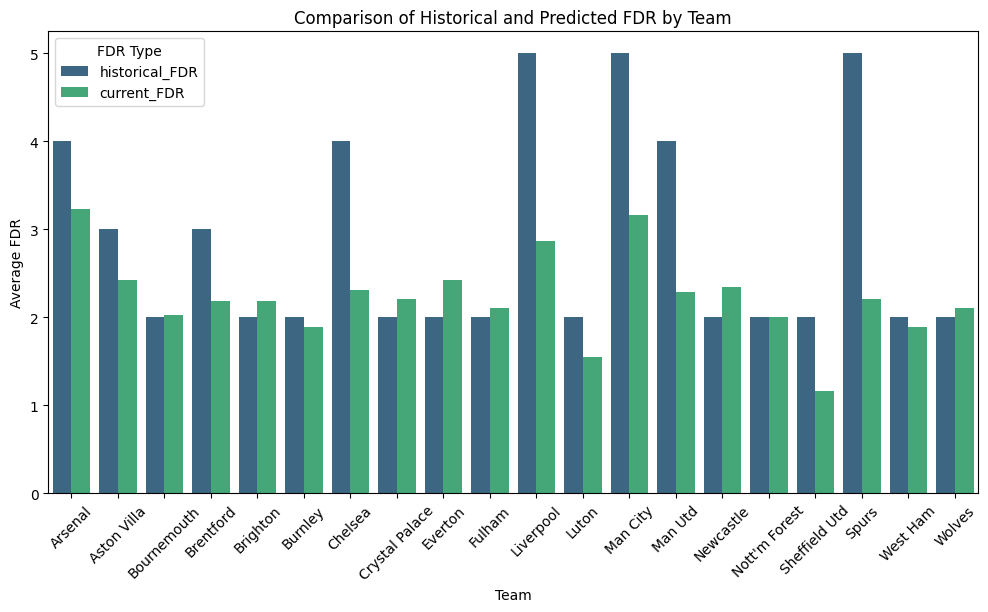

In [17]:
team_avg_fdr = test_data.groupby('opponent_team')[['historical_FDR', 'current_FDR']].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(data=team_avg_fdr.melt(id_vars='opponent_team', var_name='FDR Type', value_name='FDR'),
            x='opponent_team', y='FDR', hue='FDR Type', palette='viridis')
plt.title("Comparison of Historical and Predicted FDR by Team")
plt.xlabel("Team")
plt.ylabel("Average FDR")
plt.xticks(rotation=45)
plt.show()


C:\Users\mrnai\AppData\Local\Temp\ipykernel_29792\831071877.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=team_stats, x='team', y='win_percentage', palette='coolwarm')


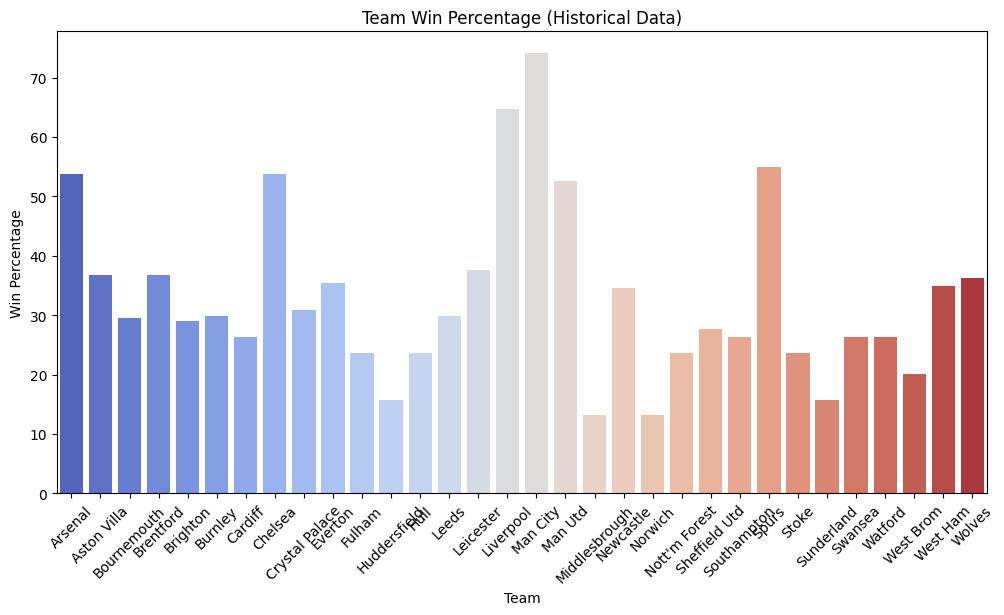

In [19]:
plt.figure(figsize=(12, 6))
sns.barplot(data=team_stats, x='team', y='win_percentage', palette='coolwarm')
plt.title("Team Win Percentage (Historical Data)")
plt.xlabel("Team")
plt.ylabel("Win Percentage")
plt.xticks(rotation=45)
plt.show()
